# use vtorch220

In [3]:
! nvidia-smi

Tue Feb  4 19:47:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.142                Driver Version: 550.142        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8              5W /   80W |    5715MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#! kill -9 111703
#! kill -9 112197
#! kill -9 115749

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
import open_clip

from src.train import fit
from src.load_data import load_data
from src.evaluate import evaluate
from src.config import get_config
from CLIP.VQADataset import VQADataset
from CLIP.classifier import Classifier
from CLIP.encoder import TextEncoder, VisualEncoder
from CLIP.VQAModel import VQAModel

In [2]:

data_path = '/home/mouatasim/0vqa_v2/bvqa/vit_roberta/dataset/val2014-resised'
train_data = load_data('/home/mouatasim/0vqa_v2/bvqa/vit_roberta/dataset/vaq2.0.TrainImages.txt')
val_data = load_data('/home/mouatasim/0vqa_v2/bvqa/vit_roberta/dataset/vaq2.0.DevImages.txt')
test_data = load_data('/home/mouatasim/0vqa_v2/bvqa/vit_roberta/dataset/vaq2.0.TestImages.txt')
train_batch_size = 512
test_batch_size = 128


clip_model_type = 'ViT-B-32'
clip_pretrained = 'laion2b_e16'
typo = 'StepLR'
print('Runing : ', typo)
modn = 'Clip'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

model_clip, _, preprocess = open_clip.create_model_and_transforms(clip_model_type, pretrained=clip_pretrained)
tokenizer = open_clip.get_tokenizer(clip_model_type)
model_clip.to(device)

Runing :  StepLR


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [3]:
classes = set([sample["answer"] for sample in train_data])

# Dictionary mapping classes
cls_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}

idx_to_cls = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}

train_dataset = VQADataset(
    train_data,
    cls_to_idx,
    preprocess,
    tokenizer,
    device,
    data_path
)

val_dataset = VQADataset(
    val_data,
    cls_to_idx,
    preprocess,
    tokenizer,
    device,
    data_path
)

test_dataset = VQADataset(
    test_data,
    cls_to_idx,
    preprocess,
    tokenizer,
    device,
    data_path
)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [4]:
text_encoder = TextEncoder(model_clip).to(device)
visual_encoder = VisualEncoder(model_clip).to(device)
classifier = Classifier().to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_tokenizer=text_encoder,
    classifier=classifier
).to(device)

model.freeze()

In [5]:
device

'cuda'

In [6]:
from src.evaluate import evaluate
def test_opt(model_path):
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    print("Val acc", val_acc)
    print("Test acc", test_acc)

In [7]:

model_path = './results/Clip/clip_StepLR.pt'
test_opt(model_path)

Val acc 0.6352459016393442
Test acc 0.6429277942631059


In [8]:
model_path = './results/Clip/clip_ControlLR.pt'
test_opt(model_path)

Val acc 0.7213114754098361
Test acc 0.7106824925816023


In [7]:
model_path = './results/Clip/clip_ExponentialLR.pt'
test_opt(model_path)

Val acc 0.5973360655737705
Test acc 0.6068249258160238


# Expermental

In [15]:
#img_path = "./sample/50_clip.png"
#question = "Is this a potluck ?"

In [22]:
model_path = './results/Clip/clip_ControlLR_best.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

<All keys matched successfully>

In [23]:
from src.predict import predict
import matplotlib.pyplot as plt

In [24]:
predicted_label = predict(model, img_path, question, tokenizer, preprocess, device)
print("The answer is:", predicted_label)

The answer is: Yes


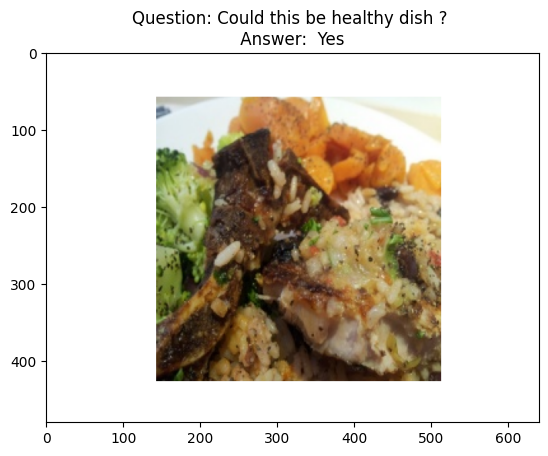

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title(f"Question: {question} \n Answer:  {predicted_label} ")
#plt.title(f"Question: {Question}\nAnswer: Truth - {Response} & Prediction - {pred_responses}")
plt.show()

#plt.savefig('./png/infer1.png')

In [13]:
model_path = './results/Clip/clip_ExponentialLR.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])

<All keys matched successfully>

In [16]:
img_path = "./sample/12_clip.png"
question = "Could this be healthy dish ?"

In [17]:
predicted_label = predict(model, img_path, question, tokenizer, preprocess, device)
print("The answer is:", predicted_label)

The answer is: No


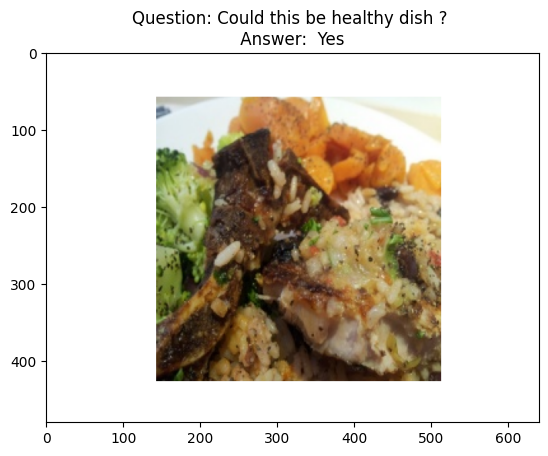

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title(f"Question: {question} \n Answer:  {predicted_label} ")
#plt.title(f"Question: {Question}\nAnswer: Truth - {Response} & Prediction - {pred_responses}")
plt.show()

#plt.savefig('./png/infer1.png')